[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fXhuSLU_CxPIHiMbELwEuuKoJih2SeQs?usp=sharing)

# Stock Price Prediction with CNN and GAF

This notebook delves into the exciting world of applying deep learning techniques to predict dynamic stock price movements. 🚀 Specifically, we leverage the power of Gramian Angular Fields (GAF) to ingeniously transform historical stock price data into visually rich images 🖼️. These "time-series images" are then fed into a Convolutional Neural Network (CNN), a powerful type of neural network adept at image analysis, for insightful classification. This approach allows us to capture intricate temporal dependencies and patterns within the data in a novel way. ✨

# Table of Contents
- [Install Libraries](#install-libraries)
- [Data Downloading](#data-downloading)
- [GAF](#gaf)
- [Train Test Split](#train-test-split)
- [Applying Class Weights](#applying-class-weights)
- [Model Training and Evaluation](#model-training-and-evaluation)


# Install Libraries<a name="install-libraries"></a>


In [16]:
%%capture
try:
    import arch
except:
    !pip install --upgrade yfinance arch tensorflow pyts
finally:
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    import seaborn as sns
    import statsmodels
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.tsa.seasonal import STL

    from arch import arch_model
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
    from sklearn import metrics
    from sklearn.neural_network import MLPRegressor
    from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    from pyts.image import GramianAngularField
    import tensorflow as tf

    import warnings
    warnings.filterwarnings('ignore')

# Data Downloading<a name="data-downloading"></a>



We begin by downloading historical stock price data using the yfinance library. We focus on the 'Close' price as our primary time series for analysis.

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

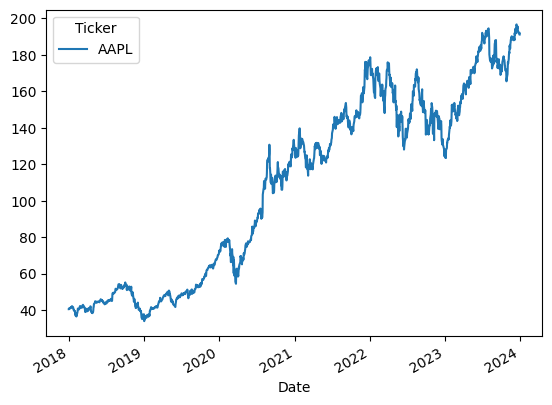

In [6]:
ticker = 'AAPL'
start = '2018-01-01'
end = '2024-01-01'
df = yf.download(ticker, start = start, end = end).dropna()
df.Close.plot()

# GAF<a name="gaf"></a>
Gramian Angular Field (GAF) is a technique that encodes a time series as a 2D image by representing each data point as a polar coordinate. The radial coordinate is the time point itself, and the angular coordinate is the scaled value of the time series at that point. This transformation allows us to capture the temporal dependencies and relationships within the time series in an image format.

In [7]:
Xdf = df.iloc[:, 0]
X_train = []
window_size = 30
for i in range(window_size, Xdf.shape[0]):
    X_train.append(Xdf[i - window_size : i])
X_train = np.array(X_train)
days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])

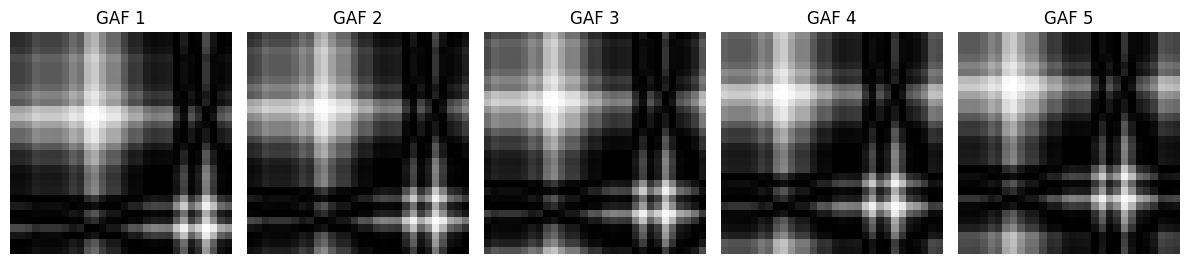

In [8]:
transformer = GramianAngularField()
X_train_new = transformer.transform(X_train)
# Plot the first 5 GAFs
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))  # Adjust figsize as needed

for i in range(5):
    axes[i].imshow(X_train_new[i], cmap='gray', interpolation='nearest')
    axes[i].set_title(f'GAF {i+1}')
    axes[i].axis('off') # Turn off axis ticks and labels for cleaner visualization

plt.tight_layout()
plt.show()

Before feeding the GAF images into the CNN, we need to prepare the corresponding labels. The label for each GAF image represents whether the stock price increased or decreased [window_size] days after the end of the time window represented by that GAF image. A label of 1 indicates an upward movement, and 0 indicates a downward movement.

In [9]:
# Generate the labels: 1 if price goes up after window_size days, 0 otherwise
y_data = []
for i in range(window_size, Xdf.shape[0] - window_size):
    y_data.append(Xdf[i] < Xdf[i + window_size])
y_data = np.array(y_data)

# Determine the examples to be used as inputs in the model and rescale them to the [0,255] scale
X_data = X_train_new[:-window_size]
for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
# We could simply write X_data = (X_data + 1)/2
X_data = X_data * 255

#Train Test Split<a name="train-test-split"></a>

To evaluate the model's ability to generalize to unseen data, we split the prepared data into training and testing sets. The training set is used to train the model, while the testing set is used to assess its performance on data it has not encountered during training.

In [10]:
# Split into train and test
train_split = 0.8
y_data_train = y_data[: int(train_split * y_data.shape[0])]
y_data_test = y_data[int(train_split * y_data.shape[0]) :]
X_data_train = X_data[: int(train_split * y_data.shape[0])]
X_data_test = X_data[int(train_split * y_data.shape[0]) :]

We will construct a CNN model by adding ``Conv2D`` and ``MaxPooling2D`` layer. By adding the ``MaxPooling2D`` layer, we can reduce the computational cost as the spatial dimension is being reduced.

In [11]:
model = tf.keras.Sequential()
# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,489 (1.10 MB)

 Trainable params: 287,489 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

# Applying Class Weights<a name="applying-class-weights"></a>

In financial time series data, the distribution of upward and downward price movements can often be imbalanced. To address this potential class imbalance, we apply class weights during model training. This gives more importance to the minority class (the class with fewer examples), helping the model learn from both classes effectively.

In [12]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)
class_weight = {0: 1 / (1 - np.mean(y_data_train)), 1: 1.0}
print(f"The class weight for 0: {class_weight[0]}")
print(f"The class weight for 0: {class_weight[1]}")

The class weight for 0: 2.786057692307692
The class weight for 0: 1.0


# Model Training and Evaluation<a name="model-training-and-evaluation"></a>

The CNN model is trained using the prepared training data. We monitor the model's performance on the validation data during training and save the model with the best validation accuracy.

In [13]:
model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1,
    callbacks=[checkpoint],
    class_weight=class_weight,
);

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4968 - loss: 11.8660

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4963 - loss: 11.6845 - val_accuracy: 0.3621 - val_loss: 1.0765
Epoch 2/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4978 - loss: 1.1635

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4951 - loss: 1.1635 - val_accuracy: 0.4552 - val_loss: 0.7954
Epoch 3/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4983 - loss: 1.2547

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4979 - loss: 1.2483 - val_accuracy: 0.6448 - val_loss: 0.9161
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4791 - loss: 1.3271 - val_accuracy: 0.4207 - val_loss: 0.7529
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4597 - loss: 1.0778 - val_accuracy: 0.4379 - val_loss: 0.7827
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5198 - loss: 1.1009 - val_accuracy: 0.4793 - val_loss: 1.1697
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5607 - loss: 1.1105 - val_accuracy: 0.4276 - val_loss: 1.0650
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5126 - loss: 1.0961 - val_accuracy: 0.4552 - val_loss: 0.7739
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5680 - loss: 1.0275 - val_accuracy: 0.5586 - val_loss: 0.9547
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5827 - loss: 1.0434 - val_accuracy: 0.5172 - val_loss: 0

In [14]:
model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_data_test, y=y_data_test)
print("Accuracy is: {:.2f}%".format(acc[1] * 100))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6123 - loss: 1.0262
Accuracy is: 64.48%


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


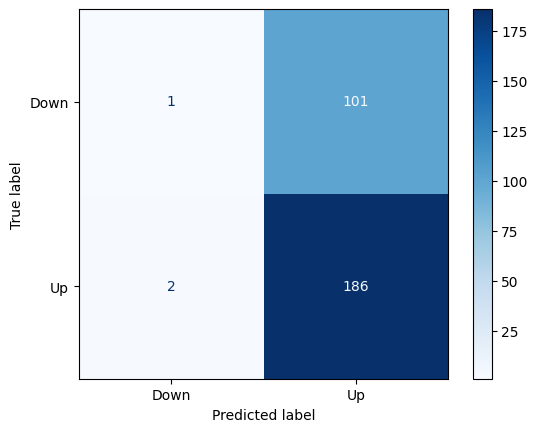

In [18]:
y_prob = model.predict(X_data_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_data_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")

In [20]:
print(classification_report(y_data_test, y_pred))

              precision    recall  f1-score   support

       False       0.33      0.01      0.02       102
        True       0.65      0.99      0.78       188

    accuracy                           0.64       290
   macro avg       0.49      0.50      0.40       290
weighted avg       0.54      0.64      0.51       290

